In [1]:
import os
import uuid
from collections import Counter
from itertools import islice
import random
import math
import time
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from matplotlib.image import imread

### Inspecting images

In [2]:
# Ispecting portraits images
ports_path = "../data/portraits"

modes = []

with os.scandir(ports_path) as it:
    for file in it:
        filepath = "{}/{}".format(ports_path, file.name)
        image = Image.open(filepath)
        modes.append(image.mode)

### Images modes

In [24]:
cmode = Counter(modes)
print(cmode)

Counter({'RGB': 14859, 'L': 131, 'RGBA': 5, 'CMYK': 2, 'P': 2, 'LA': 1})


### Ignore non-RGB

In [25]:
images_paths = []
sizes = []

with os.scandir(ports_path) as it:
    for file in it:
        filepath = "{}/{}".format(ports_path, file.name)
        image = Image.open(filepath)
        if image.mode != "RGB":
            continue
        sizes.append(image.size)
        images_paths.append(filepath)

print(len(images_paths))

14859


### Top 25 image sizes

In [4]:
rounded_sizes = [(round(s[0]/100, 0) * 100, round(s[1]/100, 0) * 100) for s in sizes]
c = Counter(rounded_sizes)
c = dict(sorted(c.items(), key=lambda item: item[1], reverse=True))
ctop = dict(islice(c.items(), 25))
ctop_by_size = dict(sorted(ctop.items(), key=lambda item: item[0][0] * item[0][1]))
ctop_percentage = {k: round(v/len(sizes), 2) for k, v in ctop.items()}

NameError: name 'sizes' is not defined

In [ ]:
# x axis: one point per key in the Counter (=unique tuple)
x=range(len(ctop_percentage))
# y axis: count for each tuple, sorted by tuple value
y=[ctop_percentage[key] for key in sorted(ctop_percentage)]
# labels for x axis: tuple as strings
ylabels=[str(t) for t in sorted(ctop_percentage)]

# plot
fig = plt.figure(figsize=(20, len(ylabels) * 1.6))
plt.barh(x, y)
# set the labels at the middle of the bars
plt.yticks([x+0 for x in x],ylabels)
plt.title("Top 25 image sizes")

### Resizing and cropping images

In [2]:
ports_resized_path = "../data/portraits_resized"

IMG_SIDE_LENGTH = 112
BATCH_SIZE = 48
istop = 5000

#cropped_paths = ["{}/CROP{}".format(ports_resized_path, fpath.split("/")[-1]) for fpath in filepaths[:istop]]

In [3]:
def resize_crop(img_paths, save_dir_path, resized_length, n, augment=False):
    
    for fpath in tqdm(img_paths[:n]):
        fname = fpath.split("/")[-1]
        croppedpath = "{}/CROP{}".format(save_dir_path, fname)

        ## open image
        img = Image.open(fpath)
        width, height = img.size

        ## resize image
        resize_factor = min(img.size) / resized_length
        new_width, new_height = width / resize_factor, height / resize_factor
        new_width = math.ceil(new_width) if new_width < resized_length else math.floor(new_width)
        new_height = math.ceil(new_height) if new_height < resized_length else math.floor(new_height)
        resized_img = img.resize((new_width, new_height))

        ### crop image
        left, top, right, bottom = 0, 0, new_width, new_height

        ## tall image
        ## cut 25% from above and 75% from below
        if new_height > new_width:
            hpx_to_crop = new_height - resized_length
            top = math.floor(hpx_to_crop * 0.25)
            bottom = new_height - math.ceil(hpx_to_crop * 0.75)

        ## wide image
        ## cut 50% from both sides
        elif new_height < new_width:
            hpx_to_crop = new_width - resized_length
            left = math.ceil(hpx_to_crop * 0.5)
            right = new_width - math.floor(hpx_to_crop * 0.5)

        ## square image
        else:
            continue

        ## crop((left, top, right, bottom))
        cropped_img = resized_img.crop((left, top, right, bottom))
        if cropped_img.size[0] != cropped_img.size[1]:
            print("OI! ---> {}".format(croppedpath))
            print(cropped_img.size)
        cropped_img.save(croppedpath)
        
        if augment:
            flipped = cropped_img.transpose(PIL.Image.FLIP_LEFT_RIGHT)
            flipped.save(croppedpath[:-4] + "FLIPPED.jpg")


    print(f"Resized and cropped all of your images.")

### Now the dataset looks like this

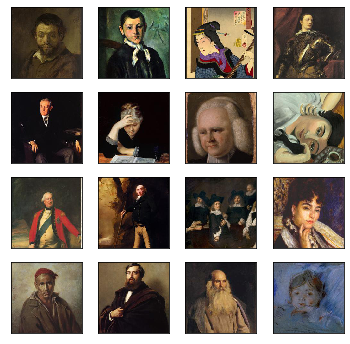

In [49]:
cropped_paths = [f"../data/portraits-cropped/{f}" for f in os.listdir("../data/portraits-cropped")]

# random.shuffle(cropped_paths)

ishow = 16
plt.ioff()
fig = plt.figure(figsize=(6,6))
for i, cpath in zip(range(ishow), cropped_paths[:16]):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = Image.open(cpath)
    plt.imshow(img, cmap=plt.cm.binary)
# plt.show()

In [59]:
fig = plt.figure(figsize=(6,6))
size = tuple(map(lambda x: int(x), tuple(fig.get_size_inches() * fig.dpi)))
print(size)
print(type(size))

(432, 432)
<class 'tuple'>


<Figure size 432x432 with 0 Axes>

# Writing images to .npy file in batches

In [5]:
def images_to_npy(images_dir_path, out_path, image_height, images_per_file, channels=3):
    n_images = len(os.listdir(images_dir_path))
    n_files = int(n_images / images_per_file) + 1
    out_paths = [f"{out_path}/ports{uuid.uuid4()}.npy" for i in range(n_files)]
    images_data = np.empty(shape=(0, image_height, image_height, channels))
    
    c = 0
    path = out_paths[c]
    # open directory with images
    with os.scandir(images_dir_path) as it:
        for file in tqdm(it):
            # read image
            img = imread(file.path).reshape((1, image_height, image_height, channels))
            # append to array of images
            images_data = np.append(images_data, img, axis=0)
            
            if len(images_data) == images_per_file:
                # write array to file
                with open(path, 'wb') as fout:
                    np.save(fout, images_data)
                    
                # reinitialize array and switch filename
                images_data = np.empty(shape=(0, image_height, image_height, channels))
                c += 1
                path = out_paths[c]

    print("Done.")

In [6]:
resize_crop(["../data/portraits/0a89b1127c6515cdff4058141a1b423cc.jpg"], "../data/test", 224, 1)

  0%|          | 0/1 [00:00<?, ?it/s]

Resized and cropped all of your images.


In [8]:
resize_crop(images_paths, "../data/ports64", 64, 15000)

NameError: name 'resize_crop' is not defined

In [7]:
images_to_npy("../data/ports64", "../data/numpy64-320", image_height=64, images_per_file=64*5, channels=3)

0it [00:00, ?it/s]

320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
Done.


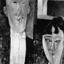

[[ 31  20  16 ...  94  97 101]
 [ 32  21  18 ...  36  39  43]
 [ 40  17  18 ...  29  34  38]
 ...
 [113  45  19 ... 131  70  57]
 [112  65  37 ... 124  51  51]
 [111  92  54 ... 129  59  71]]
[[-0.75686275 -0.84313725 -0.8745098  ... -0.2627451  -0.23921569
  -0.20784314]
 [-0.74901961 -0.83529412 -0.85882353 ... -0.71764706 -0.69411765
  -0.6627451 ]
 [-0.68627451 -0.86666667 -0.85882353 ... -0.77254902 -0.73333333
  -0.70196078]
 ...
 [-0.11372549 -0.64705882 -0.85098039 ...  0.02745098 -0.45098039
  -0.55294118]
 [-0.12156863 -0.49019608 -0.70980392 ... -0.02745098 -0.6
  -0.6       ]
 [-0.12941176 -0.27843137 -0.57647059 ...  0.01176471 -0.5372549
  -0.44313725]]


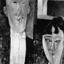

In [27]:
img = Image.open("../data/ports64-greyscale/" + os.listdir("../data/ports64-greyscale")[0])
img.show()
img = np.array(img)
print(img)
img = (img - 127.5) / 127.5
print(img)
Image.fromarray((img*127.5)+127.5).show()

In [28]:
with os.scandir("../data/ports64") as it:
    for file in tqdm(it):
        if not file.path.endswith("_LR_FLIPPED.jpg"):
            img = Image.open(file.path)
            left_right = img.transpose(Image.FLIP_LEFT_RIGHT)
            left_right.save(file.path[:-4] + "_LR_FLIPPED.jpg")

0it [00:00, ?it/s]

In [23]:
start = time.time()
images = np.zeros(shape=(0, 64, 64, 3))
c = 0
with os.scandir("../data/ports64") as it:
    for file in it:
        if len(images) % 640 == 0:
            images = np.zeros(shape=(0, 64, 64, 3))
            c += 1
            
        img = Image.open(file.path)
        img_array = np.array(img).reshape((1, 64, 64, 3))
        images = np.concatenate((images, img_array))
        
print(time.time() - start)
print(c)

KeyboardInterrupt: 

In [16]:
def to_grayscale(dir_path):
    dir_path = dir_path[:-1] if dir_path.endswith("/") else dir_path
    new_dir_path = f"{dir_path}-greyscale"
    if not os.path.exists(new_dir_path):
        os.mkdir(new_dir_path)
    
    with os.scandir(dir_path) as it:
        for file in tqdm(it):
            gr_img = ImageOps.grayscale(Image.open(file.path))
            gr_img.save(f"{new_dir_path}/{file.name}")

In [29]:
to_grayscale("../data/ports64")

0it [00:00, ?it/s]